# Time-Varying Effect of Market Uncertainties on Crude Oil Return

## 1. Outline
I examine the 12-month change in nominal WTI returns in response to economic, geopolticial and financial uncertainties, and how responses have changed over time. Since uncertainty spikes when major instabilities occur, we can thus use uncertainty as a proxy to deduce the impact of historical events on oil prices, especially when a time series of datapoints are obtained. For this study, I demonstrate how we can use an established economometrics method to estimate the average effect of uncertainty on crude returns for the sample period, before decomposing the average effect into annual datapoints.

To obtain continuous and non-proprietary measures for uncertainty, I look at established indices that approximate uncertainty: namely the Economic Policy Uncertainty Index (EPU), Geopolitical Risk Index (GPR), and CBOE Volatility Index (VIX). Shock values are defined as the difference between % changes in the index and the 12-month rolling average. I believe this construction of shock values should be robust up to a 6 month rolling average (more testing needed).

Consistent with Kilian (2008) and Kilian & Hicks (2013), I use a (non-autoregressive) distributed lag model to estimate the average effect of shocks in uncertainty over a period of 12 months. In doing so, I recognize underlying assumptions that a) shocks are predetermined, and b) shocks can be readily observed. 

Adding to the distributed lag methodology, I create a trend estimation method to obtain more granular, annual values of model coefficients. Using my method, I examine changes in the estimated annual values before checking that my method of obtaining annual coefficients provide reasonable results.

## 2. Model

### 2.1 General Model*
For the following let $WTI$ be the nominal price of WTI crude, $S$ be the shock variable and $I$ the value of the the index used. Our general model is given by:

$\Delta{WTI}_t = \alpha + \sum_{p=0}^{12} \beta_p S_{t-p} + \epsilon_t$

where

$S_t = \Delta{I_t} - \Delta{(\frac{1}{12}\sum_{j=0}^{11} I_{t-j})}$

The average magnitude of WTI response at month p after the shock is thus given by $\beta_p$.

\* Adapted from Kilian, L. (2008). A Comparison of the Effects of Exogenous Oil Supply Shocks on Output and Inflation in the G7 Countries. *Journal of the European Economic Association*, 6(1), pp 78-121.

### 2.2 Trend Estimation
To estimate $\beta_p$ for points $y_1, y_2, \ldots, y_i$, first note we can write the general model as $\Delta{WTI} = \alpha + S\beta + \epsilon$, where $S$ is a $n\times{13}$ matrix such that $n$ is the sample size. $\beta$ then becomes a $13\times1$ vector, while $\alpha, \epsilon, \Delta{WTI}$ are represented by $n\times1$ vectors.

To get to our trend estimation formula, let $\phi$ be the set of sample observations containing $n$ number of observations. We shall further decompose $\phi$ into subsets $x$ and $z$ like so:

$\Phi = \{\text{population observations}\}$

$\phi\subset{\Phi}$

$y_i = \{x \cap z | x \cup z = \phi\}$

so our $\beta$ estimate $\hat\beta$ at point $y_i$ can be written as

$\hat\beta_{y_i} = \frac{1}{2}(\beta_x + \beta_z)$

If we then select $y_1, y_2,\ldots, y_i$ at regular intervals, we should then be able to get an idea of how the $\beta$ values in $\phi$ change over time regardless of how many observations are in $y_i$. This estimation is useful for solving the problem of insufficient sample size in  for OLS estimatation.

Intuitively (using Python to demonstrate), it is like being given a list of numbers ```num_list``` and asked to find what the values are is while only being able to obtain values using a mean function requiring at least 2 inputs. Here the mean function is analogous for OLS estimation, which is linear and requires a minimum sample size to run. Hence, we can estimate ```num_list[n]``` via```1/2(mean(num_list[:n+1]) + mean(num_list[n:])) for range(1, len(num_list)-1)```. While this method may not be accurate, it should give us a good estimation of the overall trend of the series. Overall, the shape of the estimates would follow the trend of the actual values and accuracy will differ depending on how the variance of the true series is distributed.

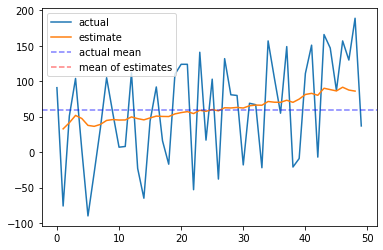

The graphs above shows the estimated vs actual values of a randomly generated series (see EstimatorSim.ipynb) using the averaging method. By analogy, if the actual values represent the true $\beta$ values, our estimation will still be able to discerne trends in the data if not changes between points.

The annotation for cell 8 details how this technique is put into practice. Section 4 also details a sanity check where I compare the mean of the estimated series to the estimated sample average obtained via the general model.

## 3. Data
WTI data is sourced from EIA, while the EPU and GPR indices were sourced from the respective authors and VIX monthly adjusted closing values from Yahoo Finance.

In [1]:
from utils import *
env()

--------- Dependencies ---------
python: 3.8.10 | packaged by conda-forge | (default, May 11 2021, 06:25:23) [MSC v.1916 64 bit (AMD64)]
numpy: 1.21.0
pandas: 1.2.4
matplotlib: 3.4.2
statsmodels: 0.13.0


In [2]:
wti = load('data/WTI.csv').pct_change().dropna()
spot = clean_series('spot', wti)
c1 = clean_series('contract_1', wti)
c3 = clean_series('contract_3', wti)

### 3.1 EPU

In [3]:
epu = load('data/EPUGlobal.csv')
epu_shock = calc_shock('GEPU_current', epu)

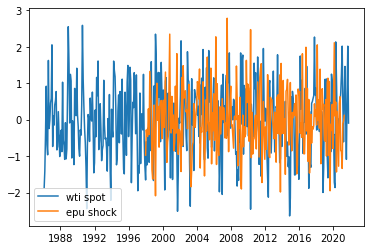

In [4]:
plt.plot(spot, label='wti spot')
plt.plot(epu_shock, label='epu shock')
plt.legend()

*Note that all time series data are standardized annually and seasonally adjusted by month.*

In [5]:
model1 = dl('spot', 'GEPU_current', spot.join(epu_shock))
model2 = dl('contract_1', 'GEPU_current', c1.join(epu_shock))
model3 = dl('contract_3', 'GEPU_current', c3.join(epu_shock))

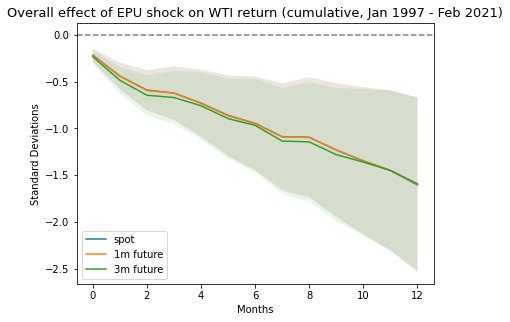

In [6]:
draw((model1, model2, model3), labels=('spot', '1m future', '3m future'), cumulative=True)
plt.title('Overall effect of EPU shock on WTI return (cumulative, Jan 1997 - Feb 2021)', fontsize=13)
plt.ylabel('Standard Deviations')
plt.xlabel('Months')
plt.show()

This is the cumulative shock response at months 0 to 12 after the shock occurs with 1 standard error bands. Due to the transformations done on the time series to ensure an unbiased fit, the proper interpretation is that (ceteris paribus) a 1 standard deviation increase in the shock variable (change in EPU relative to the 12-month rolling average) corresponds to a total -1.5 standard deviation decrease in WTI returns over 12 months.

*Note that standard deviations are computed annually (see annotation above for time series data).*

In [7]:
spot_shift1 = time_shift('spot', 'GEPU_current', spot.join(epu_shock), start_yr=2000, end_yr=2018)
c1_shift1 = time_shift('contract_1', 'GEPU_current', c1.join(epu_shock), start_yr=2000, end_yr=2018)
c3_shift1 = time_shift('contract_3', 'GEPU_current', c3.join(epu_shock), start_yr=2000, end_yr=2018)

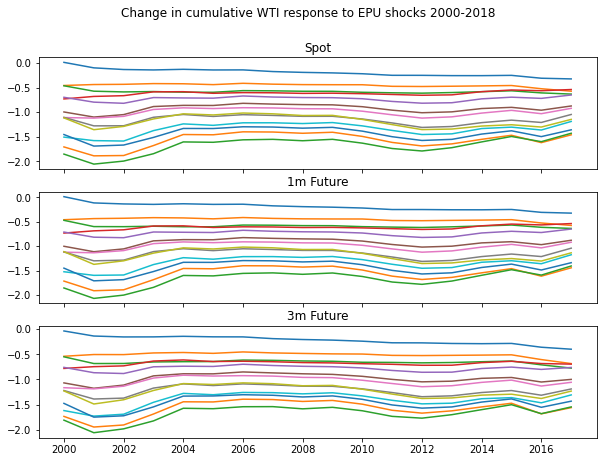

In [8]:
fig, axs = plt.subplots(3, sharex=True, figsize=(10,7))
fig.suptitle('Change in cumulative WTI response to EPU shocks 2000-2018')
axs[0].plot(spot_shift1)
axs[0].set_title('Spot')
axs[1].plot(c1_shift1)
axs[1].set_title('1m Future')
axs[2].plot(c3_shift1)
axs[2].set_title('3m Future')
plt.show()

The above graphs show how the coefficients estimates change over time for response to EPU shocks, where each line represents cumulative response at month p in the model. As per my proposed method, coefficients were estimated by running two series of regressions in two 'directions'. The 'forward' (in time) estimates were gotten by starting the sample from 2000-01-01 and iteratively excluding the oldest 12 months from the sample size up to 2018-01-01. The 'backward' estimates were gotten by ending the sample at 2000-12-31 for the first run and iteratively increasing the sample size by 12 months each run up to 2018-12-31. The mean between coefficient estimates for the forward and backward runs were then taken to exclude anomalies and difference in trends at the outer edges of the data not included in the period shown. I believe that this method of estimation solves the problem of being unable to generate 12-month estimates for a single year due to there being only 12 datapoints available. While this method may not generate the most accurate results, I believe it should give a reasonable representation of any temporal trends.

From the graphs, we see a gradual tightening of cumulative effect of EPU shocks on WTI. WTI spot and futures are quicker to adjust to shocks in the first couple of months, while the cumulative effects are not felt as sharply 6-12 months onwards. We also see there are periods such as 2001, 2012 and 2016 when the effect of EPU shocks were longer-lasting than usual. Coincidentally, these periods respectively correspond with the 9/11 attacks, European debt crisis and Brexit, so it is expected. However, we do not see the 2008 global financial crisis having an effect.

### 3.2 GPR

In [9]:
gpr = load('data/GPRGlobal.csv')
gpr_shock = calc_shock('GPRI', gpr)

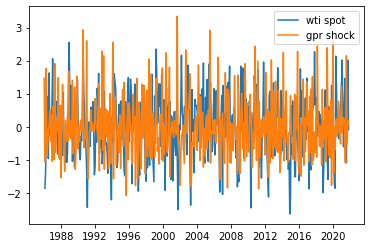

In [10]:
plt.plot(spot, label='wti spot')
plt.plot(gpr_shock, label='gpr shock')
plt.legend()

In [11]:
model4 = dl('spot', 'GPRI', spot.join(gpr_shock))
model5 = dl('contract_1', 'GPRI', c1.join(gpr_shock))
model6 = dl('contract_3', 'GPRI', c3.join(gpr_shock))

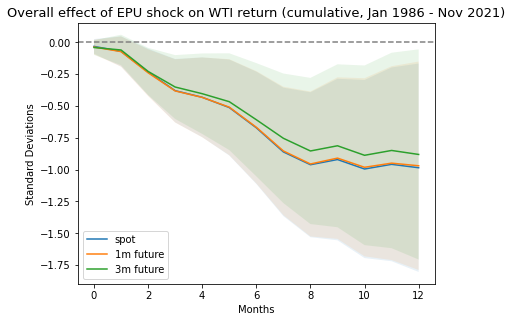

In [12]:
draw((model4, model5, model6), labels=('spot', '1m future', '3m future'), cumulative=True)
plt.title('Overall effect of EPU shock on WTI return (cumulative, Jan 1986 - Nov 2021)', fontsize=13)
plt.ylabel('Standard Deviations')
plt.xlabel('Months')
plt.show()

Here we see that on average, a 1 standard deviation in GPR shock corresponds to a total -1 standard deviation in WTI returns in the next 12 months.

In [13]:
spot_shift2 = time_shift('spot', 'GPRI', spot.join(gpr_shock), start_yr=1989, end_yr=2019)
c1_shift2 = time_shift('contract_1', 'GPRI', c1.join(gpr_shock), start_yr=1989, end_yr=2019)
c3_shift2 = time_shift('contract_3', 'GPRI', c3.join(gpr_shock), start_yr=1989, end_yr=2019)

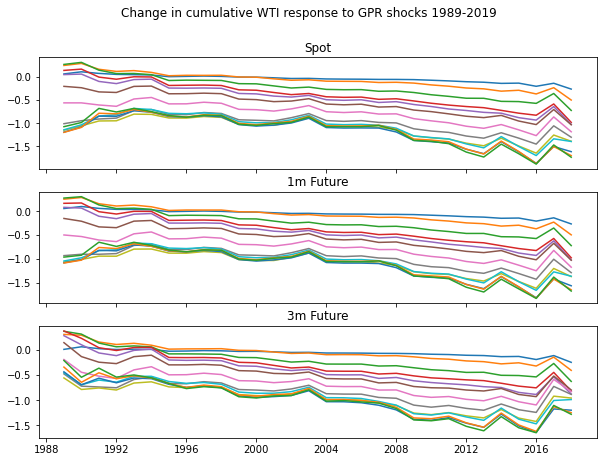

In [14]:
fig, axs = plt.subplots(3, sharex=True, figsize=(10,7))
fig.suptitle('Change in cumulative WTI response to GPR shocks 1989-2019')
axs[0].plot(spot_shift2)
axs[0].set_title('Spot')
axs[1].plot(c1_shift2)
axs[1].set_title('1m Future')
axs[2].plot(c3_shift2)
axs[2].set_title('3m Future')
plt.show()

From the graph above, we see that WTI is responding more negatively to GPR shocks like with EPU. However, the cumulative effect of GPU shocks also have a greater effect on GPR responses 6-12 months on. Disruptions to this trend can be seen in 2003, 2011, 2014 and 2018, where 6-12 month cumulative effects were reduced relative to the shocks. Coincidentally, these periods respectively correspond with the US invasion of Iraq, start of the Arab Spring, the Russo-Ukranian war and the Kerch Strait Incident. The reduced shocks should not be taken as a sign that those events were insignificant, but rather they represent supply-side disruptions that helped push up prices rather than depress them. We can also see that around the first Gulf War in 1990 (when production was impeded), first-quarter returns responded positively to geopolitical uncertainty.

### 3.3 VIX

In [15]:
vix = load('data/VIX.csv')
vix_shock = calc_shock('VIX', vix)

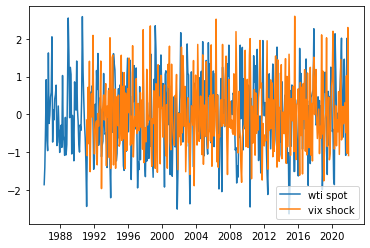

In [16]:
plt.plot(spot, label='wti spot')
plt.plot(vix_shock, label='vix shock')
plt.legend()

In [17]:
model7 = dl('spot', 'VIX', spot.join(vix_shock))
model8 = dl('contract_1', 'VIX', c1.join(vix_shock))
model9 = dl('contract_3', 'VIX', c3.join(vix_shock))

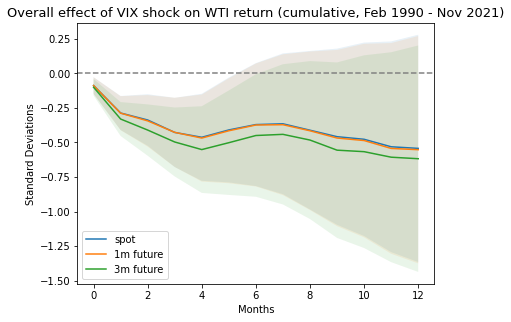

In [18]:
draw((model7, model8, model9), labels=('spot', '1m future', '3m future'), cumulative=True)
plt.title('Overall effect of VIX shock on WTI return (cumulative, Feb 1990 - Nov 2021)', fontsize=13)
plt.ylabel('Standard Deviations')
plt.xlabel('Months')
plt.show()

In [19]:
spot_shift3 = time_shift('spot', 'VIX', spot.join(vix_shock), start_yr=1994, end_yr=2019)
c1_shift3 = time_shift('contract_1', 'VIX', c1.join(vix_shock), start_yr=1994, end_yr=2019)
c3_shift3 = time_shift('contract_3', 'VIX', c3.join(vix_shock), start_yr=1994, end_yr=2019)

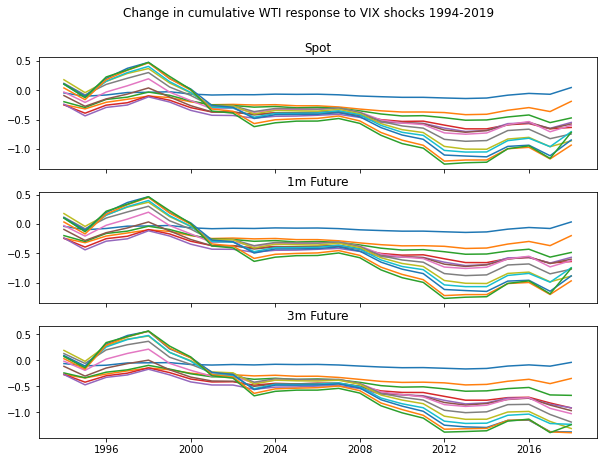

In [20]:
fig, axs = plt.subplots(3, sharex=True, figsize=(10,7))
fig.suptitle('Change in cumulative WTI response to VIX shocks 1994-2019')
axs[0].plot(spot_shift3)
axs[0].set_title('Spot')
axs[1].plot(c1_shift3)
axs[1].set_title('1m Future')
axs[2].plot(c3_shift3)
axs[2].set_title('3m Future')
plt.show()

This relationship is really interesting - it seems that major S&P500 downturns (1991, 2000, 2008) decrease 6-12 month crude returns in response to VIX shocks over the next 4 years, after which responses remain stable until the next downturn. There was also a period from 1995 to 2000 when 6-12 months cumulative returns were positive with every shock in the VIX, coinciding with the dotcom bubble and Greenspan's period of 'irrational exuberance'. Additionally, initial returns today appear to move towards positive correlation with VIX shocks.

## 4. Sanity Check

To sanity check my results, I will try to estimate the shape of the overall curve by averaging the coefficients. Since I used time spans close to the entirety of the dataset (leaving around 3 years each side to ensure reasonable sample size for end-of-period estimates), I would expect the estimates to be close to the actual values.

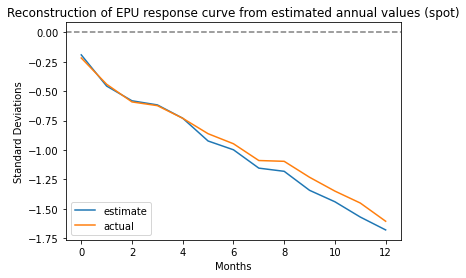

In [21]:
estimate1 = pd.DataFrame({'estimate': [spot_shift1[i].mean() for i in range(13)]})
plt.plot(estimate1, label='estimate')
plt.plot(np.cumsum(model1.params[1:]).reset_index(drop=True), label='actual')
plt.axhline(y=0, linestyle='--', color='grey')
plt.title('Reconstruction of EPU response curve from estimated annual values (spot)')
plt.legend()
plt.ylabel('Standard Deviations')
plt.xlabel('Months')
plt.show()

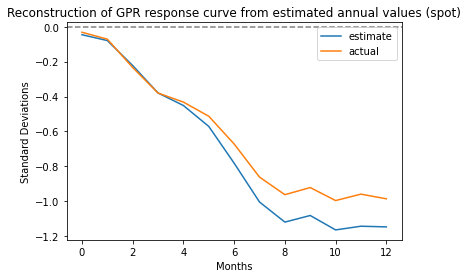

In [22]:
estimate2 = pd.DataFrame({'estimate': [spot_shift2[i].mean() for i in range(13)]})
plt.plot(estimate2, label='estimate')
plt.plot(np.cumsum(model4.params[1:]).reset_index(drop=True), label='actual')
plt.axhline(y=0, linestyle='--', color='grey')
plt.title('Reconstruction of GPR response curve from estimated annual values (spot)')
plt.legend()
plt.ylabel('Standard Deviations')
plt.xlabel('Months')
plt.show()

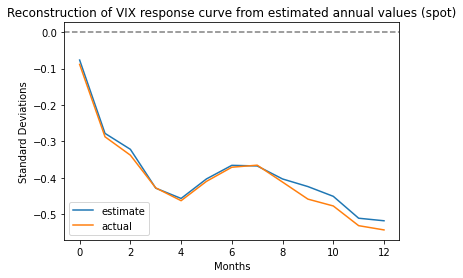

In [23]:
estimate3 = pd.DataFrame({'estimate': [spot_shift3[i].mean() for i in range(13)]})
plt.plot(estimate3, label='estimate')
plt.plot(np.cumsum(model7.params[1:]).reset_index(drop=True), label='actual')
plt.axhline(y=0, linestyle='--', color='grey')
plt.title('Reconstruction of VIX response curve from estimated annual values (spot)')
plt.legend()
plt.ylabel('Standard Deviations')
plt.xlabel('Months')
plt.show()

The estimated annual estimates are shown to be good representations of the overall curve without scaling, which indicates that, overall, our series of estimated coefficients are reasonable in shape. However, for GPR shocks, our estimate from 4 months onwards appear to be a bit lower than the actual, which indicate that our trend estimation method may not have sufficiently accounted for extreme values (likely those supply side disruptions caused by war).

The results also affirm my theory that linear models can be reliably decomposed into more granular invervals by iterating regression estimates over windows in the overall sample, which is great for gaining greater clarity on how coefficients change over time. I believe this method may also be scaled to monthly/quarterly frequency.